# 从原始文本到词嵌入
### Step 1：下载IMDB数据的原始文本

In [2]:
import os

imdb_dir = 'D://ML/aclImdb/'

train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='gb18030', errors='ignore')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Step 2：对数据进行分词

In [4]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing import sequence
import numpy as np

maxlen = 100
maxlen = 100 
training_samples = 200 
validation_samples = 10000 
max_words = 10000 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = sequence.pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0]) 
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

Found 88583 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Step 3：对嵌入进行预处理

In [5]:
# 解析GloVe词嵌入文件

glove_dir = 'D://ML/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='gb18030', errors='ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 399917 word vectors.


In [6]:
# 准备 GloVe 词嵌入矩阵
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 

### Step 4：定义模型

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()

model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Step 5： 在模型中加载 GloVe 嵌入

In [8]:
# 将预训练的词嵌入加载到 Embedding 层中
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

### Step 6：训练模型与评估模型

In [9]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 112ms/step - loss: 1.3920 - acc: 0.5050 - val_loss: 0.6996 - val_acc: 0.5015
Epoch 2/10
7/7 [==============================] - 1s 89ms/step - loss: 0.6331 - acc: 0.6150 - val_loss: 0.6861 - val_acc: 0.5533
Epoch 3/10
7/7 [==============================] - 1s 86ms/step - loss: 0.6621 - acc: 0.7200 - val_loss: 0.7419 - val_acc: 0.5252
Epoch 4/10
7/7 [==============================] - 1s 107ms/step - loss: 0.4575 - acc: 0.7550 - val_loss: 0.7019 - val_acc: 0.5562
Epoch 5/10
7/7 [==============================] - 1s 86ms/step - loss: 0.2659 - acc: 0.9450 - val_loss: 0.8033 - val_acc: 0.5256
Epoch 6/10
7/7 [==============================] - 1s 92ms/step - loss: 0.2286 - acc: 0.9250 - val_loss: 0.6969 - val_acc: 0.5774
Epoch 7/10
7/7 [==============================] - 1s 90ms/step - loss: 0.1288 - acc: 0.9950 - val_loss: 0.9772 - val_acc: 0.5149
Epoch 8/10
7/7 [==============================] - 1s 94ms/step - loss: 0.1174 - acc: 0.9950 - v

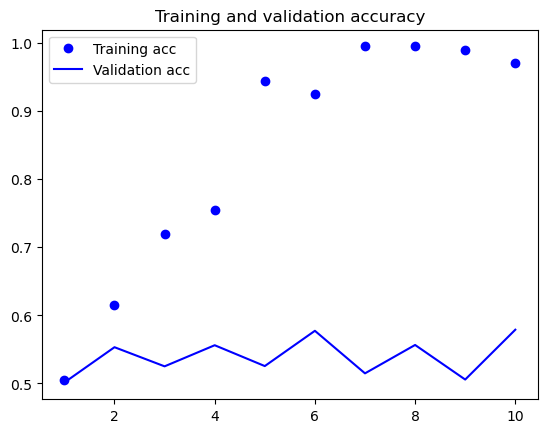

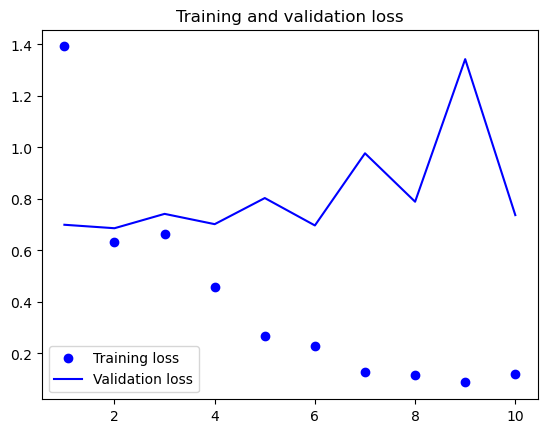

In [10]:
# 绘制结果

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
# 在不使用预训练词嵌入的情况下，训练相同的模型

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                320032    
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 2s 139ms/step - loss: 0.6952 - acc: 0.5100 - val_loss: 0.6913 - val_acc: 0.5310
Epoch 2/10
7/7 [==============================

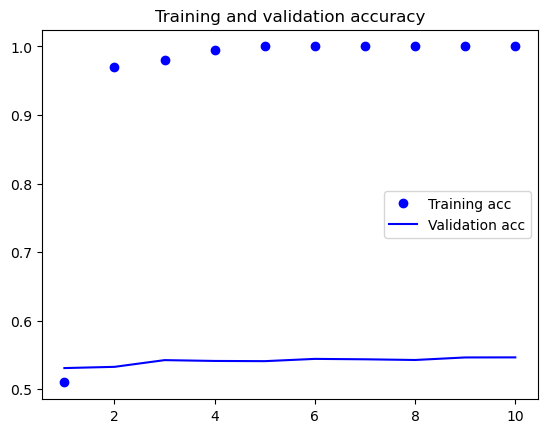

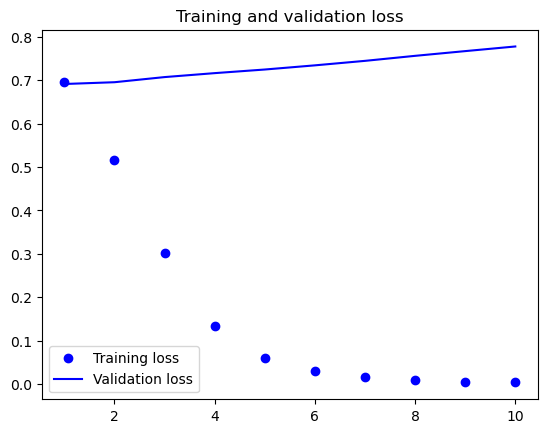

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Step 7：评估模型

In [15]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='gb18030', errors='ignore')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = sequence.pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [17]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 8s 2ms/step - loss: 0.7475 - acc: 0.5744


[0.7475159168243408, 0.5744400024414062]